# Исследование успешности компьютерных игр

## Вводные по проекту

### Контекст проекта

Заказчик исследования - интернет-магазин, который продаёт игры по всему миру. Необходимо на базе открытых исторических данных о продажах игр, оценок пользователей и экспертов выявить определяющие успешность игры закономерности, для того, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Цель и задачи проекта

Выявить закономерности, определяющие успешность игры:
1. Проанализировать имеющиеся данные о продажах игр.
2. Составить портрет клиента по регионам.
3. Определив актуальный период данных, найти потенциально прибыльные платформы для рекламных кампаний.

### Описание данных

__Исходные данные (датафрейм `games`)__
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

Аббревиатура ESRB - это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### План работы над проектом

1. Загрузить библиотеки и данные.
2. Проверить и предобработать данные.
3. Изучить игры по годам, платформам и жанрам.
4. Определить актуальный период для прогнозирования.
5. Составить портрет клиента по регионам.
6. Проверить гипотезы.
7. Написать выводы и составить рекомендации.

## Загрузка и настройка библиотек

In [2]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import numpy as np
from plotly import graph_objects as go
import plotly.express as px
import datetime
import calendar
import itertools
from datetime import datetime, timedelta
from collections import Counter   
from scipy import stats as st


# настройки библиотек                    
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 15})
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)
pd.set_option('display.precision',2)

print('Библиотеки успешно импортированы и настроены.')

Библиотеки успешно импортированы и настроены.


## Загрузка данных

Для загрузки данных и вывода информации зададим функции.

In [3]:
# создание функции
def def_info(df, rc=1, d=1, i=1, c=1, s=1):
    
    # описание функции и фрагмент для вывода: print(def_info.__doc__)
    """
    Эта функция выводит информацию о датафрейме:
    - количество строк и столбцов (в том числе пустых)
    - информация о дубликатах
    - сводная информация (аналог info)
    - названия столбцов
    - пример(ы) строк(и) датафрейма (можно указать количество)
    
    Принимает на вход:
    - `df` - датафрейм
    - `rc` - определяет вывод информации о количестве строк и столбцов (1 или 0)
    - `d` - определяет вывод информации о дубликатах (1 или 0)
    - `i` - определяет вывод сводной информации (1 или 0)
    - `c` - определяет вывод информации о названиях столбцов (1 или 0)
    - `s` - определяет вывод примера строки (значения больше 0 выводят указанное количество строк)
    
    Если указать только датафрейм, будет выведено всё.

    """
    
# получение и вывод информации о количестве строк и столбцов
    if rc == 1:
        empty_rows = (df.isna().all(axis=1)).sum()
        empty_rows_per = (df.isna().all(axis=1)).mean()
        empty_cols = (df.isna().all(axis=0)).sum()
        empty_cols_per = (df.isna().all(axis=0)).mean()
        print(
            f"- количество строк: {df.shape[0]}, полностью пустых - {empty_rows} ({empty_rows_per:.0%})")
        print(
            f"- количество столбцов: {df.shape[1]}, полностью пустых - {empty_cols} ({empty_cols_per:.0%})")
    
# создание таблицы для вывода сводной информации (аналог info(),
# но с указанием количества и доли пропусков для каждого столбца)    
    if i == 1:
        data_info = df.notnull().sum().to_frame(name='данные')
        data_info['пропуски'] = df.isnull().sum()
        data_info['% пропусков'] = round((df.isnull().sum() / len(df)), 2)
        data_info['тип данных'] = df.dtypes

# вывод таблицы с цветовой индикацией количества данных и пропусков
        display(data_info.style
            .format({'% пропусков': '{:.0%}'})
            .set_caption('сводная информация')
            .bar(subset=['данные'], color='lightgreen')
            .applymap(lambda x: 'background-color: peachpuff' if x > 0 else '' if x == 0 else '',
                      subset=['пропуски'])
            .bar(subset=['% пропусков'], color='coral')
            .set_table_styles([{'selector': 'caption', 
                                'props': [('color', 'coral'), ('font-size', '14px')]
                               }])
           )

# получение и вывод информации о количестве полных дубликатов
    if d == 1:
        duplicates = df.duplicated()
        num_duplicates = duplicates.sum()
        if num_duplicates == 0:
            print('Полных дубликатов нет')
        else:
            print('\033[1m\033[38;5;209m\nдубликаты\033[0m')    
            print('Количество полных дубликатов:', num_duplicates)
            
# вывод названий столбцов
    if c == 1:
        print('\033[1m\033[38;5;209m\nстолбцы\033[0m')
        print(df.columns.tolist())
        
# вывод нескольких строк для примера (можно указать количество)
    if s > 0:
        print('\033[1m\033[38;5;209m\nпример строк(и)\033[0m')
        display(df.sample(s))

In [4]:
# создание функции
def def_load_data(df_name, file_name, file_type, path=None, name=None, sep=None, sheet_name=0, header=0):

    # описание функции и фрагмент для вывода: print(def_load_data.__doc__)
    """
    Эта функция загружает данные из файла (csv или excel) и преобразует их в датафрейм для работы.
    Затем выводит основную информацию по файлу с помощью функции def_info
    Принимает на вход:
    - `df_name` - название создаваемого датафрейма
    - `file_name` - название загружаемого файла
    - `file_type` - тип загружаемого файла
    - `path` - путь к файлу (если файл находится в другой директории)
    - `name` - название таблицы для читателя, поясняющее содержимое файла
    - `sep` - разделитель для csv файла
    - `sheet_name` - имя листа в excel файле
    - `header` - номер строки, которую нужно использовать в качестве заголовка таблицы
    Обязательными являются только первые 3 параметра, остальные используются при необходимости.

    """
    
    # вывод информации об источнике
    print(
        '\033[1m\033[38;5;209mИСТОЧНИК\n{} - {}\033[0m'.format(file_name, name))
    
    # загрузка из источника определённого типа в датафрейм       
    if file_type == 'xls' or file_type == 'xlsx':
        try:
            df = pd.read_excel(path, sheet_name=sheet_name, header=header)
        except:
            df = pd.read_excel(file_name, sheet_name=sheet_name, header=header)
    elif file_type == 'csv':
        try:
            df = pd.read_csv(path, sep=sep)
        except:
            df = pd.read_csv(file_name, sep=sep)
    else:
        print('Тип файла не распознан')
        return
    globals()[df_name] = df
        
    # вывод информации о созданном датафрейме с помощью функции
    def_info(df, i=1, s=3, d=1, c=1)

Теперь загрузим данные проекта.

In [5]:
# загрузка данных с помощью функции
def_load_data('df_games', 'games.csv', 'csv',
              path='/datasets/games.csv',
              name='данные по играм')

ИСТОЧНИК
games.csv - данные по играм
- количество строк: 16715, полностью пустых - 0 (0%)
- количество столбцов: 11, полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
Name,16713,2,0%,object
Platform,16715,0,0%,object
Year_of_Release,16446,269,2%,float64
Genre,16713,2,0%,object
NA_sales,16715,0,0%,float64
EU_sales,16715,0,0%,float64
JP_sales,16715,0,0%,float64
Other_sales,16715,0,0%,float64
Critic_Score,8137,8578,51%,float64
User_Score,10014,6701,40%,object


Полных дубликатов нет

столбцы
['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales', 'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating']

пример строк(и)


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
3940,Monsters vs. Aliens,DS,2009.0,Action,0.33,0.13,0.00,0.05,47.0,tbd,E
15445,Saki: Achiga-Hen Portable,PSP,2013.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
2687,Bayonetta 2,WiiU,2014.0,Action,0.32,0.28,0.10,0.06,91.0,8.2,M


<div style="border:solid green 2px; padding: 20px">

<b>ВЫВОДЫ по разделу</b><br><br>
Полных дубликатов нет, пропуски в разном объёме есть почти в половине столбцов. Типы данных почти везде коорректны.<br><br>
Требуется небольшая предобработка:
1. Названия столбцов нужно привести к "хорошему" стилю.
2. Необходимо проверить и обработать пропуски.
3. Проверить (и по возможности поменять) типы данных в столбцах с датой и пользовательским рейтингом.
4. Создать дополнительный столбец с суммарными продажами во всех регионах.
    
</div>

## Первичное изучение и предобработка данных

Мы уже отметили, что некоторые столбцы имеют пропуски. И так как вероятно часть из них нужно будет удалить, сохраним в переменную общее количество строк исходного датафрейма, чтобы можно было оценить потери.

In [73]:
# подсчёт количества строк
raw_len = len(df_games)

Добавим функцию для оценки изменений.

In [7]:
# создание функции
def def_df_del(df, raw_len):
    # описание функции
    """
    Функция определяет, насколько уменьшилась длина датафрейма относительно изначальной длины
    (после удаления части строк).
    
    Принимает на вход:
    - df - текущий датафрейм
    - raw_len - длина исходного датафрейма

    """
    current_len = len(df)
    reduction_percentage = ((raw_len - current_len) / raw_len) * 100
    print(f"Длина датафрейма уменьшилась на {reduction_percentage:.2f}% от изначальной длины.")

### Изменение названий столбцов

Для удобства работы приведём все названия столбцов к нижнему регистру.

In [8]:
# приведение названий столбцов к нижнему регистру
df_games.columns = df_games.columns.str.lower()

# вывод новых названий
df_games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Столбцы `name`, `platform` и `genre`

Проверим данные в столбцах с названиями и жанрами игр, а также с названиями платформ.

Мы знаем, что в столбце с названиями платформ нет пропусков, а в столбцах с названиями и жанрами игр есть - выведем их.

In [9]:
# вывод строк с пропусками
df_games.query('name.isnull() or genre.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


 У столбца `name` всего 2 пропуска (совпадающие с пропусками в столбце `genre` - удалим их.

In [10]:
# удаление пропусков
df_games.dropna(subset=['name'], inplace=True)

In [11]:
# оценка изменений после удаления
def_df_del(df_games, raw_len)

Длина датафрейма уменьшилась на 0.01% от изначальной длины.


Так как для анализа нам нужны будут уникальные названия платформ и жанров, проверим, нет ли неявных дубликатов (из-за ошибок в написании). Для удобства просмотра столбцов напишем функцию, которая будет выводить уникальные значения и долю пропусков.

In [12]:
# создание функции
def def_sorted_unique(df, column, header):
    
    # описание функции
    """
    Функция выводит отсортированные уникальные значения заданного столбца и долю пропусков.
    
    Принимает на вход:
    - df - датафрейм
    - column - столбец
    - header - заголовок
    """
    
    # подсчет и вывод уникальных значений
    sorted_values = df[column].dropna().unique()
    sorted_values = sorted(sorted_values, key=lambda x: (isinstance(x, str), x))
    sorted_values_str = ', '.join(map(str, sorted_values))
    
    # подсчет и вывод доли пропусков
    total_rows = df.shape[0]
    missing_values = df[column].isnull().sum()
    missing_percentage = (missing_values / total_rows) * 100
    
    print(f"\033[1;31m{header}\033[0m")
    print(sorted_values_str)
    print(f"\nДоля пропусков: {missing_percentage:.0f}%")

In [13]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'platform',
                  'Уникальные значения столбца `platform`:')

Уникальные значения столбца `platform`:
2600, 3DO, 3DS, DC, DS, GB, GBA, GC, GEN, GG, N64, NES, NG, PC, PCFX, PS, PS2, PS3, PS4, PSP, PSV, SAT, SCD, SNES, TG16, WS, Wii, WiiU, X360, XB, XOne

Доля пропусков: 0%


In [14]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'genre',
                  'Уникальные значения столбца `genre`:')

Уникальные значения столбца `genre`:
Action, Adventure, Fighting, Misc, Platform, Puzzle, Racing, Role-Playing, Shooter, Simulation, Sports, Strategy

Доля пропусков: 0%


Всё в порядке - значения указаны корректно.

Проверим столбец `name` на дубликаты.

In [15]:
# вывод информации
print('Количество дубликатов в столбце name:', df_games.duplicated(subset='name').sum())

Количество дубликатов в столбце name: 5154


В этом столбце могут быть дубликаты, так как многие игры могли выходить на разных платформах.  
Проверим, будут ли дубликаты в сочетании полей "игра", "платформа", "жанр" и "год выпуска".

In [16]:
# проверка дубликатов
duplicates = df_games.duplicated(subset=['name', 'platform', 'genre', 'year_of_release'], keep=False)

# вывод результата на экран
if duplicates.any():
    print("Найдены дубликаты:")
    display(df_games[duplicates])
else:
    print("Дубликатов нет.")

Найдены дубликаты:


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Тут полное совпадение по названию, платформе, жанру и году выпуска игры. Различаются только значения по странам. Удалим дубликат (оставим только одну строку).

In [17]:
# удаление дубликата
df_games.drop_duplicates(
    subset=['name', 'platform', 'genre', 'year_of_release'], keep='first', inplace=True)

# проверка дубликатов
duplicates = df_games.duplicated(subset=['name', 'platform', 'genre', 'year_of_release'], keep=False)

# вывод результата на экран
if duplicates.any():
    print("Найдены дубликаты:")
    display(df_games[duplicates])
else:
    print("Дубликатов нет.")

Дубликатов нет.


### Столбец `year_of_release`

Теперь обработаем календарный столбец - с информацией о дате выхода игры.  

In [18]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'year_of_release',
                  'Уникальные значения столбца `year_of_release`:')

Уникальные значения столбца `year_of_release`:
1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0

Доля пропусков: 2%


Для чистоты данных такой объём можно удалить.  
Так как год - это целое число, изменим тип данных с float на int.

In [19]:
# удаление пропусков
df_games.dropna(subset=['year_of_release'], inplace=True)

In [20]:
# оценка изменений после удаления
def_df_del(df_games, raw_len)

Длина датафрейма уменьшилась на 1.63% от изначальной длины.


In [21]:
# изменение типа данных столбца
df_games.year_of_release = df_games.year_of_release.astype(int)

# проверка
print('Новый тип данных в столбце `year_of_release`:', df_games['year_of_release'].dtype)
display(df_games.sample(3))

Новый тип данных в столбце `year_of_release`: int64


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
9463,Sally's Salon,DS,2008,Simulation,0.12,0.0,0.00,0.01,NaN,tbd,E
14036,Chaos;Head Noah,X360,2009,Adventure,0.00,0.0,0.04,0.00,NaN,NaN,NaN
12477,Legend of Kay,DS,2010,Action,0.06,0.0,0.00,0.00,NaN,tbd,E


### Столбцы продаж: `na_sales`, `eu_sales`, `jp_sales`, `other_sales`

В этих столбцах нет пропусков. Данные представлены в нужном формате. Ничего менять не будем.

Посмотрим, есть ли нулевые продажи в каком-либо регионе.

In [22]:
# вывод среза с нулевыми продажами
df_games.query('na_sales == 0 and eu_sales == 0 and jp_sales == 0 and other_sales == 0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16676,G1 Jockey 4 2008,PS3,2008,Sports,0.0,0.0,0.0,0.0,NaN,NaN,NaN
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.0,0.0,0.0,0.0,NaN,NaN,NaN


Вероятно эти игры не достигли минимального порога продаж в 10 тыс. копий, чтобы информация о продажах была отображена. Уберём эти две игры из данных.

In [23]:
# удаление строк
df_games.drop(index=[16676, 16709], inplace=True)

In [24]:
# оценка изменений после удаления
def_df_del(df_games, raw_len)

Длина датафрейма уменьшилась на 1.64% от изначальной длины.


### Столбец `total_sales`

Для дальнейшей работы создадим общий столбец со всеми продажами.

In [25]:
# добавление нового столбца
df_games['total_sales'] = (
    df_games['na_sales'] + df_games['eu_sales'] + df_games['jp_sales'] + df_games['other_sales']
)
# вывод нескольких строк для проверки
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Столбцы оценок: `critic_score`, `user_score`, `rating`

Изучим столбцы оценок (с оценкой критиков, оценкой пользователей и рейтингом).  
Мы уже знаем, что во всех этих столбцах довольно много пропусков. Но также очевидно, что вряд ли возможно как-то смыслово заполнить эти пропуски.

Выведем уникальные значения столбцов. И посмотрим, все ли данные попадают в обозначенный диапазон.  

In [26]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'critic_score',
                  'Уникальные значения столбца `critic_score`:')

Уникальные значения столбца `critic_score`:
13.0, 17.0, 19.0, 20.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0

Доля пропусков: 51%


Здесь значения попадают в заданный диапазон.  
Пропусков больше половины (вероятно, не по всем играм производились оценки).  
Заполнить их смыслово не получится, а удаление такого большого объёма может повлиять на результат исследования. Поэтому оставим как есть.

In [27]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'user_score',
                  'Уникальные значения столбца `user_score`:')

Уникальные значения столбца `user_score`:
0, 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, tbd

Доля пропусков: 40%


Числовые значения столбца `user_score` также попадают в заданный диапазон, но встречается ещё буквенное обозначение: tbd.  
TBD означает to be detemined, то есть "подлежит уточению", это значит, что пользовательская оценка этой игра ещё не была определена. Посмотрим, как много таких значений.

In [28]:
# подсчёт количества и доли значений
total_count = df_games['name'].count()
count_tbd = df_games.query('user_score == "tbd"')['name'].count()
percentage_tbd = (count_tbd / total_count) * 100

# вывод информации
print(f"Всего {count_tbd} значений TBD в датафрейме, что составляет {percentage_tbd:.2f}% от общего количества.")

Всего 2376 значений TBD в датафрейме, что составляет 14.45% от общего количества.


Для целей нашего исследования правильнее всего будет заменить это значение на пропуск, и затем изменить тип данных на float. Пропуски этого столбца мы тоже не будем обрабатывать, так как их заполнение или удаление может исказить данные.

In [29]:
# замена значений на пропуски
df_games['user_score'] = df_games['user_score'].replace('tbd', np.NaN)

# изменение типа данных столбца
df_games['user_score'] = df_games['user_score'].astype('float64')

In [30]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'user_score',
                  'Уникальные значения столбца `user_score`:')

Уникальные значения столбца `user_score`:
0.0, 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7

Доля пропусков: 55%


In [31]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'rating',
                  'Уникальные значения столбца `rating`:')

Уникальные значения столбца `rating`:
AO, E, E10+, EC, K-A, M, RP, T

Доля пропусков: 41%


Относительно пропусков в этом столбце можем предпложить, что большая их часть приходится на Японию или Европу, так как там свои системы рейтинга (PEGI — европейская рейтинговая система компьютерных и видеоигр
CERO — японская рейтинговая организация). Проверить это можно будет позже уже в рамках исследования.
Также встречается значение RP ("Rating Pending" - "Рейтинг ожидается"), что означает, что игра ещё не получила свой рейтинг от организации ESRB. Заменим это значение на пропуск, а затем всем пропускам присвоим "rating unknown".  

Ещё в этом столбце встречается неявный дубликат: значение `K-E` ("Kids to Adults") больше не используется - теперь вместо него обозначение `E` ("Everyone"). Заменим `K-E` на `E`.  

In [32]:
# замена значений
df_games['rating'] = df_games['rating'].replace('K-A', 'E')

df_games['rating'] = df_games['rating'].replace('RP', np.NaN)
df_games['rating'] = df_games['rating'].fillna('rating unknown')

In [33]:
# вывод информации с помощью функции
def_sorted_unique(df_games, 'rating',
                  'Уникальные значения столбца `rating`:')

Уникальные значения столбца `rating`:
AO, E, E10+, EC, M, T, rating unknown

Доля пропусков: 0%


In [34]:
# вывод информации по обновлённому датафрейму с помощью функции
def_info(df_games, s=3, d=1, c=0)

- количество строк: 16441, полностью пустых - 0 (0%)
- количество столбцов: 12, полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
name,16441,0,0%,object
platform,16441,0,0%,object
year_of_release,16441,0,0%,int64
genre,16441,0,0%,object
na_sales,16441,0,0%,float64
eu_sales,16441,0,0%,float64
jp_sales,16441,0,0%,float64
other_sales,16441,0,0%,float64
critic_score,7982,8459,51%,float64
user_score,7462,8979,55%,float64


Полных дубликатов нет

пример строк(и)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3285,Metroid Prime: Trilogy,Wii,2009,Shooter,0.42,0.05,0.0,0.14,91.0,9.3,T,0.61
4015,SpongeBob SquarePants: Creature from the Krusty Krab,Wii,2006,Platform,0.44,0.02,0.0,0.04,57.0,5.6,E,0.50
12760,Viewtiful Joe: Red Hot Rumble,GC,2005,Action,0.04,0.01,0.0,0.00,62.0,6.9,T,0.05


<div style="border:solid green 2px; padding: 20px">

<b>ВЫВОДЫ по разделу</b><br><br>
1. Мы изучили и предобработали исходные данные: в части столбцов удалили пропуски (1.64% от изначальной длины), в части столбцов оставили пропуски (оценки критиков и пользователей невозможно восстановить, а удаление такого большого объёма исказить данные). В столбце rating также оставили пропуски, но так как там буквенные обозначения, заменили их на значение `rating unknown`. 
2. Проверили данные на неявные дубликаты - удалили найденное.
3. Привели названия столбцов к "хорошему" стилю.
    
</div>

## Исследовательский анализ данных

In [35]:
# вывод сводной информации по исходным данным
print('Всего на',  df_games['platform'].nunique(), 'платформе',
      'представлено', df_games['name'].nunique(), 'игр в',
      df_games['genre'].nunique(), 'жанрах.')
print('\nДиапазон дат датасета:', 
      df_games['year_of_release'].min(),
      '-', df_games['year_of_release'].max(), 'гг.')

Всего на 31 платформе представлено 11425 игр в 12 жанрах.

Диапазон дат датасета: 1980 - 2016 гг.


### Игры по годам

Посмотрим, как много игр выпускалось в разные годы и определим актуальный для исследования период.

Диапазон дат довольно большой - посмотрим на распределение игр.  
Создадим для этого функцию.

In [36]:
# создание функции
def def_count_games_by_column(df, column, column_name, for_title, sort_by=0):
    
    # описание функции
    """
    Функция определяет...
    
    Принимает на вход:
    - df - текущий датафрейм
    - column - столбец, по которому будет проводиться анализ
    - column_name - название столбца для отображения
    - for_title - текст для заголовка
    - sort_by - параметр для указания сортировки результата (по умолчанию сортировка по количеству игр).

    """
    
    # группировка и сортировка данных
    df_grouped = df.groupby(column).count()['name'].reset_index()
    df_grouped.rename(columns={'name': 'количество игр', column: column_name}, inplace=True)
    
    if sort_by == 1:
        df_grouped = df_grouped.sort_values(by=[column_name])
    elif sort_by == 0:
        df_grouped = df_grouped.sort_values(by=['количество игр'], ascending=False)
    
    # вывод таблицы
    display(df_grouped.style
            .background_gradient(cmap='YlOrRd', subset=['количество игр'])
            .set_caption('РАСПРЕДЕЛЕНИЕ ИГР<br>ПО ' + for_title.upper())
            .set_table_styles([{'selector': 'caption', 
                                    'props': [('color', 'coral'), ('font-size', '15px')]
                                   }]))
    
    # вывод графика
    plt.figure(figsize=(20, 8))
    sns.barplot(data=df_grouped, x=column_name, y='количество игр')
    plt.title('КОЛИЧЕСТВО ИГР ПО '+ for_title.upper(), color='red')
    plt.xlabel(column_name)
    plt.ylabel('количество игр')
    plt.xticks(rotation=45)
    plt.show()

,год,количество игр
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


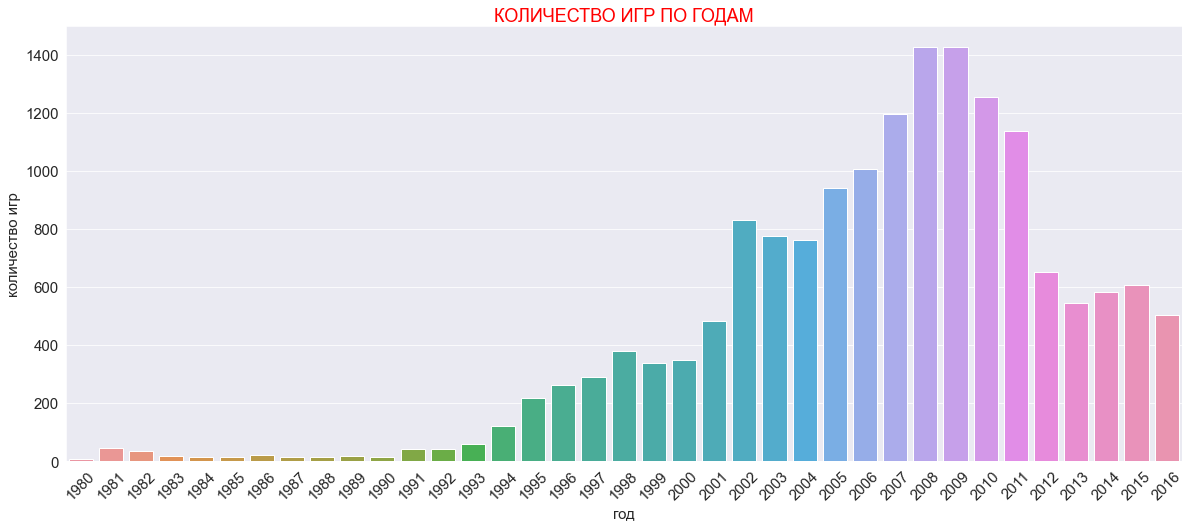

In [37]:
# вывод таблицы с помощью функции
def_count_games_by_column(df_games, 'year_of_release', 'год', 'годам', sort_by=1)

И и по таблице, и по графику хорошо заметно, что сначала в год игр выпускалось не так много (первые 13 лет - меньше 50). Пик приходится 2008-2009 годы - 1425-1426), далее идёт спад до приблизительно 500-600 игр в год.

### Игры по платформам

Посмотрим, как много игр выпускалось для каждой платформы.

,платформа,количество игр
16,PS2,2126
4,DS,2121
17,PS3,1304
26,Wii,1286
28,X360,1232
19,PSP,1193
15,PS,1190
13,PC,957
6,GBA,811
29,XB,803


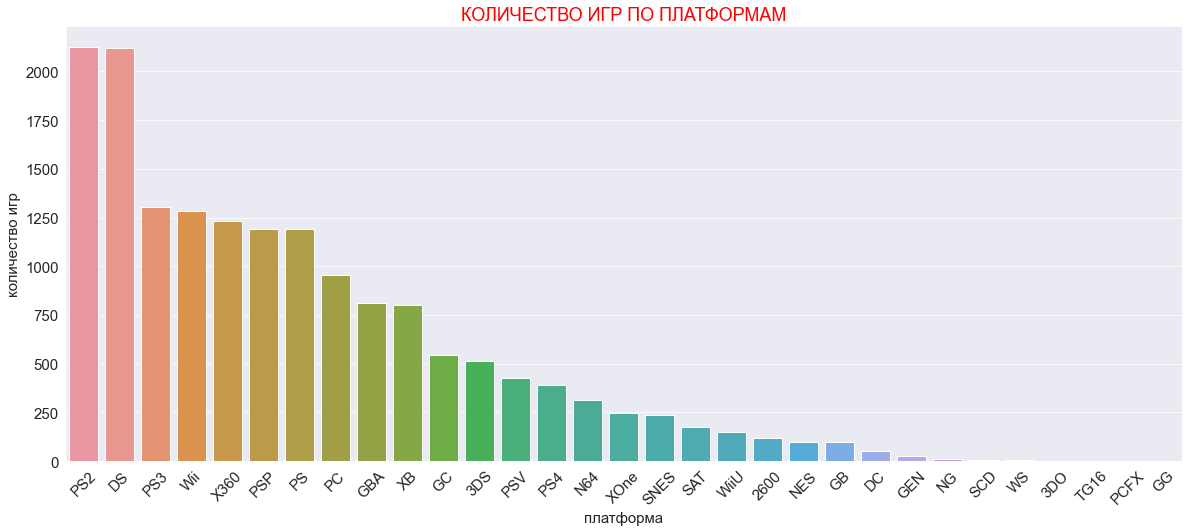

In [38]:
# вывод таблицы с помощью функции
def_count_games_by_column(df_games, 'platform', 'платформа', 'платформам')

Здесь мы видим довольно большой разброс: от 1 игры на платформе 'GG' до 2126 игр на платформе 'PS2'.

### Лайфтайм платформ

Посмотрим, как менялись продажи по платформам - выберем для этого самые топовые платформы (с наибольшими суммарными продажами).

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


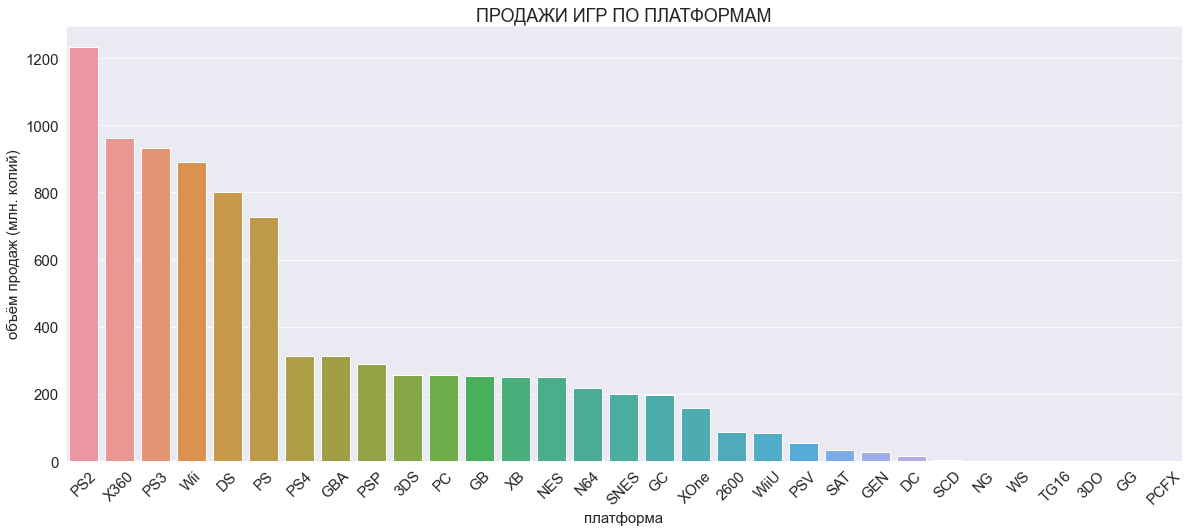

In [39]:
# создание сводной таблицы
sales_by_platforms = (
    df_games.groupby('platform')
    .agg({'total_sales':'sum'})
    .sort_values('total_sales', ascending=False)
    .reset_index()
)

# вывод по убыванию суммарных продаж
display(sales_by_platforms)

# вывод графика
plt.figure(figsize=(20, 8))
sns.barplot(data=sales_by_platforms, x='platform', y='total_sales')
plt.title('ПРОДАЖИ ИГР ПО ПЛАТФОРМАМ')
plt.xlabel('платформа')
plt.ylabel('объём продаж (млн. копий)')
plt.xticks(rotation=45)
plt.show()

Больше всего продаж с значительным отрывом принесли игры на платформе PS2. После этой платформы следуют X360 и PS3. На шестом месте располагается платформа PS, после чего наблюдается заметное падение в продажах. Сохраним топ-6 платформ по продажам и посчитаем распределение игр для этих платформ по годам.

In [40]:
# создание среза датасета с лидирующими платформами
top_platforms = sales_by_platforms['platform'].head(6).tolist()
games_for_top_platforms = df_games.query('platform in @top_platforms')

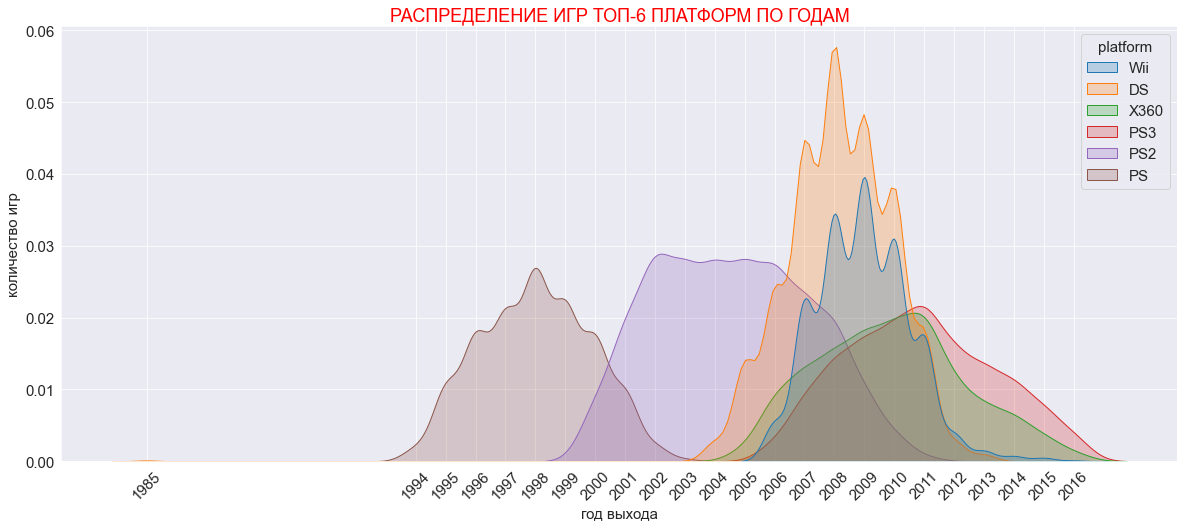

In [41]:
# создание и вывод графика
plt.figure(figsize=(20, 8))
plot = sns.kdeplot(data=games_for_top_platforms, x='year_of_release', hue='platform', fill=True)
plt.title('РАСПРЕДЕЛЕНИЕ ИГР ТОП-6 ПЛАТФОРМ ПО ГОДАМ', color='red')
plt.xlabel('год выхода')
plt.ylabel('количество игр')
plot.set_xticks(games_for_top_platforms['year_of_release'].unique())
plt.xticks(rotation=45)

plt.show()

Визуально почти все платформы имеют одинаковый временной диапазон.  
Посмотрим, какая платформа выпадает из этого правила (имеет хвост в 1985 году).

ПЛАТФОРМА DS


,год,количество игр
0,1985,1
1,2004,23
2,2005,118
3,2006,201
4,2007,376
5,2008,492
6,2009,403
7,2010,323
8,2011,153
9,2012,23


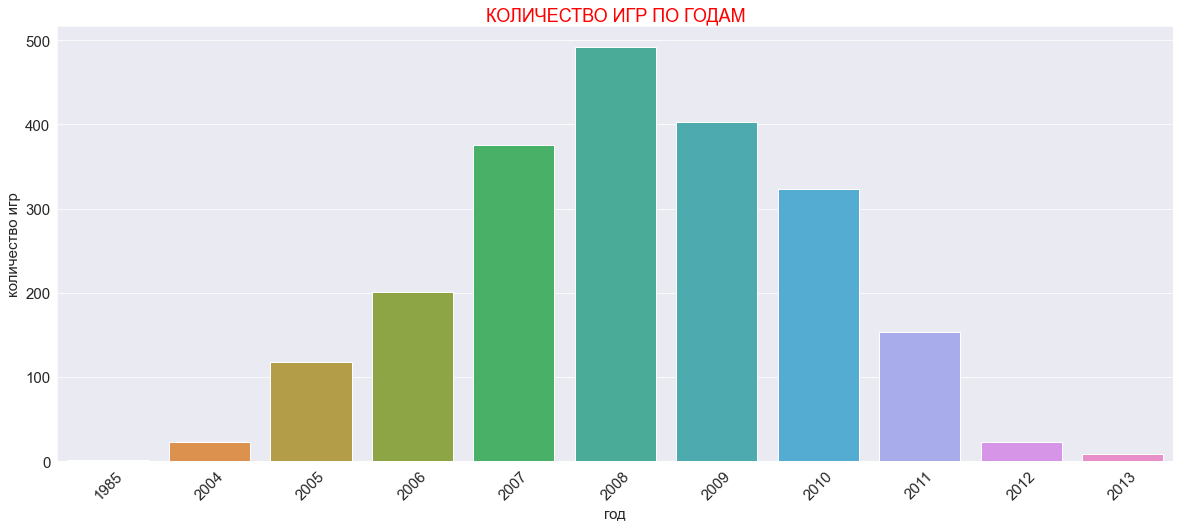

In [42]:
# определение платформы и вывод информации о ней
platform_year_1985 = games_for_top_platforms.query('year_of_release == 1985')['platform'].to_list()

print(f"ПЛАТФОРМА {', '.join(platform_year_1985)}")

# вывод таблицы с помощью функции
def_count_games_by_column(games_for_top_platforms.query('platform == @platform_year_1985'),
                          'year_of_release', 'год', 'годам', sort_by=1)

У платформы `DS` в 1985 году была выпущена всего одна игра. Затем следующая игра была выпущена только в 2004 году. Если верить Википедии, консоль вышла в 2004 году, поэтому строку 1985 года вообще можно считать выборосом.  
Общий лайфтайм посчитаем без этого года.

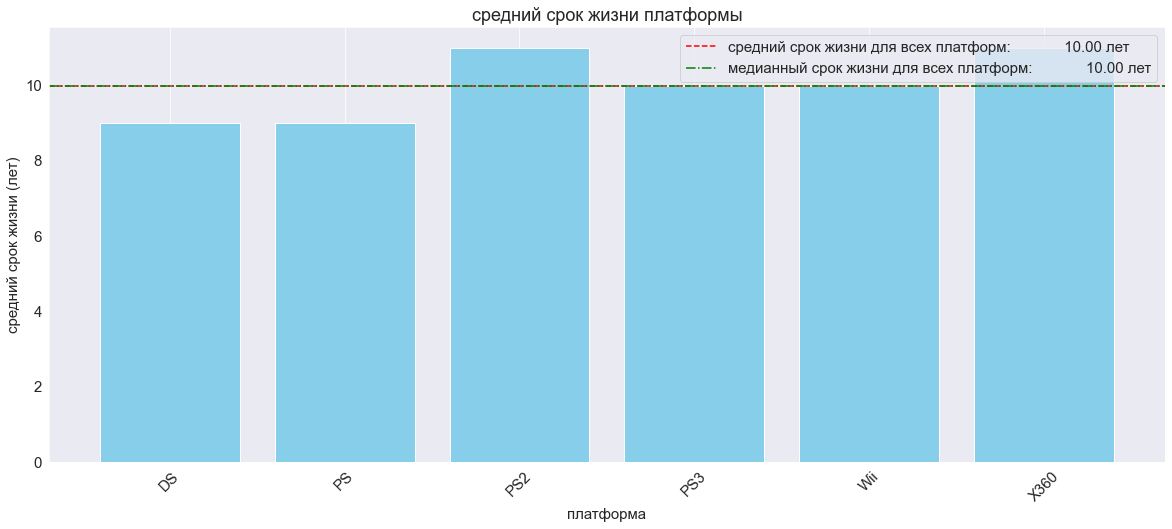

In [43]:
# создание датафрейма с начальным и конечным годом выпуска игр для каждой платформы
platform_lifespans = (
    games_for_top_platforms.query('year_of_release > 1985')
    .groupby('platform')['year_of_release'].agg(['min', 'max']).reset_index())

# вычисление среднего срока жизни платформы
platform_lifespans['average_lifespan'] = platform_lifespans['max'] - platform_lifespans['min']

# вычисление общего среднего срока жизни для всех платформ
overall_average_lifespan = platform_lifespans['average_lifespan'].mean()

# вычисление медианнанного срока жизни для всех платформ
overall_median_lifespan = platform_lifespans['average_lifespan'].median()

# построение и вывод графика
plt.figure(figsize=(20, 8))
plt.bar(platform_lifespans['platform'], platform_lifespans['average_lifespan'], color='skyblue')
plt.axhline(y=overall_average_lifespan, \
            color='r', linestyle='--', label=f'средний срок жизни для всех платформ: \
            {overall_average_lifespan:.2f} лет')
plt.axhline(y=overall_median_lifespan, \
            color='g', linestyle='-.', label=f'медианный срок жизни для всех платформ: \
            {overall_median_lifespan:.2f} лет')
plt.title('средний срок жизни платформы')
plt.xlabel('платформа')
plt.ylabel('средний срок жизни (лет)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')

plt.show()


Средний (и медианный) срок жизни платформ - 10 лет.  
Посмотрим, на какой год в среднем приходятся пиковые значения для платформ (когда выпускается больше всего игр).

In [44]:
# группировка данных по платформам и годам выпуска игр
platform_first_release = (
    games_for_top_platforms.query('year_of_release > 1985')
    .groupby('platform')['year_of_release'].min().reset_index())
platform_first_release


# группировка данных по платформе и году выпуска, подсчет количества игр
platforms_max_years = (
    games_for_top_platforms.query('year_of_release > 1985')
    .groupby(['platform', 'year_of_release'])
    .size().reset_index(name='count'))

# нахождение года с максимальным количеством игр для каждой платформы
max_years_idx = platforms_max_years.groupby('platform')['count'].idxmax()
platform_max_games_year = platforms_max_years.loc[max_years_idx]


# объединение данных по году первой игры и году достижения максимума
platform_years_diff = pd.merge(platform_first_release, platform_max_games_year, on='platform')
platform_years_diff['years_to_max_games'] = (
    platform_years_diff['year_of_release_y'] - platform_years_diff['year_of_release_x'])

# создание таблицы с информацией о платформе,
#годе первой игры и количестве лет до достижения максимума по играм
top_platform_lifetime = (
    platform_years_diff[['platform', 'year_of_release_x', 'year_of_release_y', 'years_to_max_games']])
top_platform_lifetime.columns = (['платформа', 'год выпуска платформы','год макс. кол-ва игр', 'пик'])

# вывод информации
print("\033[1;31mЛАЙФТАЙМ ТОПОВЫХ ПЛАТФОРМ\033[0m")
display(top_platform_lifetime)
liftime_max = round(top_platform_lifetime['пик'].mean())
print(
    f"В среднем пиковое значение приходится на {liftime_max} год жизни платформы.")

ЛАЙФТАЙМ ТОПОВЫХ ПЛАТФОРМ


,платформа,год выпуска платформы,год макс. кол-ва игр,пик
0,DS,2004,2008,4
1,PS,1994,1998,4
2,PS2,2000,2002,2
3,PS3,2006,2011,5
4,Wii,2006,2009,3
5,X360,2005,2011,6


В среднем пиковое значение приходится на 4 год жизни платформы.


Итак, средний срок жизни платформ - 10 лет, а пик выпуска игр приходится на 4 год жизни (диапазон выхода в пик - от 2 до 6 лет).

Интересно, что после выхода консоли нового поколения, продолжают выходить игры и на консоль старого поколения (видно на примере серии PS).

### Выделение периода для анализа

Для дальнейшего исследования и прогнозов на 2017 год нам необходимо взять актуальные (более свежие) данные. Учитывая предыдущие наблюдения, лучше всего взять данные за 4 года. Но так как данные за 2016 год неполные, возьмём данные начиная с 2012 года. До этого года был пик по количеству выпускаемых данных, а начиная с 2012 произошёл спад и количество выпускаемых игр стабилизировалось.

In [45]:
# сохранение среза в новом датафрейме
df_current_games = df_games.query('year_of_release >= 2012').reset_index(drop=True)

# вывод информации по датафрейму
def_info(df_current_games)

- количество строк: 2885, полностью пустых - 0 (0%)
- количество столбцов: 12, полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
name,2885,0,0%,object
platform,2885,0,0%,object
year_of_release,2885,0,0%,int64
genre,2885,0,0%,object
na_sales,2885,0,0%,float64
eu_sales,2885,0,0%,float64
jp_sales,2885,0,0%,float64
other_sales,2885,0,0%,float64
critic_score,1311,1574,55%,float64
user_score,1530,1355,47%,float64


Полных дубликатов нет

столбцы
['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating', 'total_sales']

пример строк(и)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2764,Dokuro,PSV,2012,Action,0.0,0.0,0.01,0.0,76.0,8.0,E10+,0.01


### Продажи игр по платформам

Посмотрим на продажи игр по платформам за актуальный период.

Наиболее перспективными по количеству выпускаемых игр (и возможно по продажам) могут быть платформы, появивишиеся около 4-6 лет назад. Выведем такие платформы.

In [46]:
# группировка данных по платформам и годам выпуска игр
platform_first_release = (
    df_games
    .groupby('platform')['year_of_release'].min().reset_index())
platform_first_release.query('year_of_release >= 2010')

,platform,year_of_release
2,3DS,2011
18,PS4,2013
20,PSV,2011
27,WiiU,2012
30,XOne,2013


Получилось 5 платформ, у которых могут быть сейчас (или в ближайшем будущем) хорошие показатели.

Посмотрим, какая платформа лидирует по продажам.

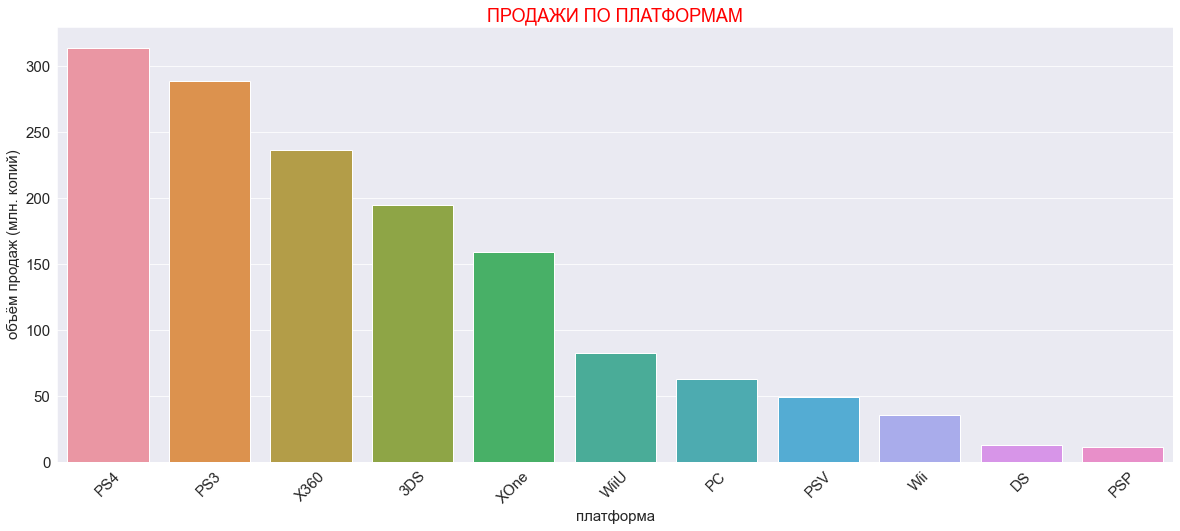

In [47]:
# создание сводной таблицы
current_sales_by_platforms = (
    df_current_games.groupby('platform')
    .agg({'total_sales':'sum'})
    .sort_values('total_sales', ascending=False)
    .reset_index()
)

# создание и вывод графика
plt.figure(figsize=(20, 8))
sns.barplot(data=current_sales_by_platforms, x='platform', y='total_sales')
plt.title('ПРОДАЖИ ПО ПЛАТФОРМАМ', color='red')
plt.xlabel('платформа')
plt.ylabel('объём продаж (млн. копий)')
plt.xticks(rotation=45)
plt.show()

По продажам однозначно лидирует PS4.  
Посмотрим теперь на продажи в динамике.

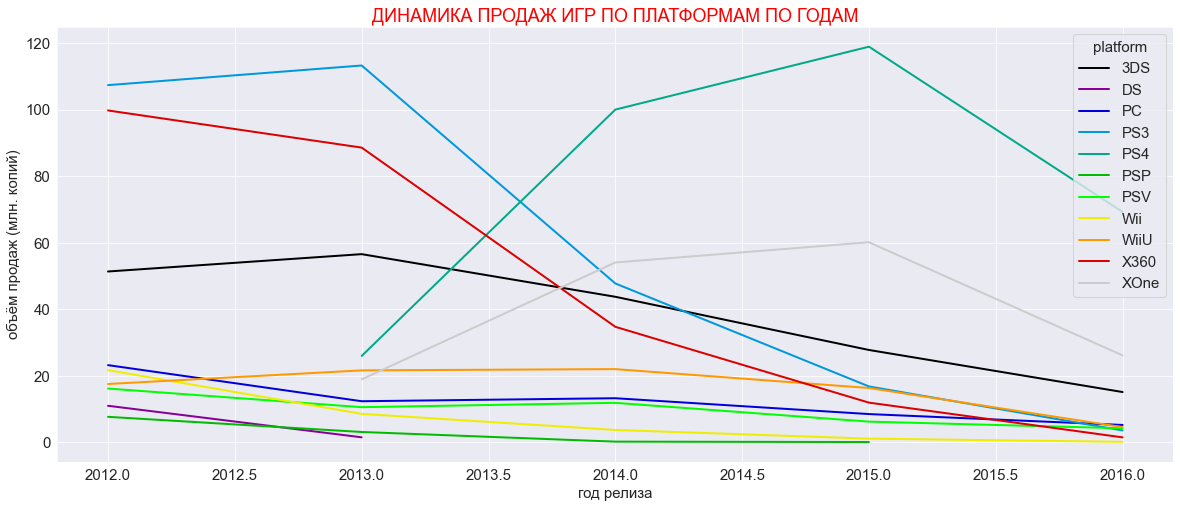

In [48]:
# cоздание сводной таблицы
current_games_dinamic = df_current_games.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum'
)

# создание и вывод графика
ax = current_games_dinamic.plot(figsize=(20, 8), colormap='nipy_spectral', linewidth=2)
ax.set_title('ДИНАМИКА ПРОДАЖ ИГР ПО ПЛАТФОРМАМ ПО ГОДАМ', color='red')
ax.set_xlabel('год релиза')
ax.set_ylabel('объём продаж (млн. копий)')

plt.show()

Можно отметить падение у всех платформ к 2016 коду. Наиболее резкое снижение у PS3 и X360.  
Наиболее перспективными на данном этапе кажутся следующие поколения этих консолей: PS4 и XOne (самые свежие из представленных - появились в 2013 году).

Построим ящики с усами по глобальным продажам игр в разбивке по платформам.

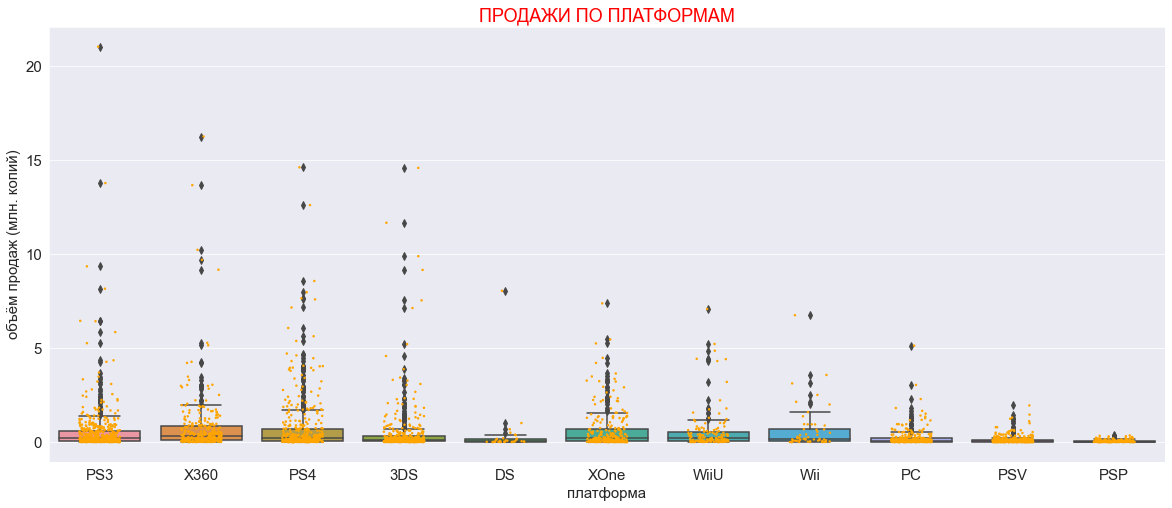

In [49]:
# построение и вывод графика
plt.figure(figsize=(20, 8))
ax = sns.boxplot(data=df_current_games, x='platform', y='total_sales')
ax = sns.stripplot(x='platform', y='total_sales', data=df_current_games, color="orange", jitter=0.2, size=2.5)
plt.title('ПРОДАЖИ ПО ПЛАТФОРМАМ', color='red')
plt.xlabel('платформа')
plt.ylabel('объём продаж (млн. копий)')

plt.show()

Довольно много выбросов (возможно это игр-хиты) - рассмотрим внимательнее основную часть.

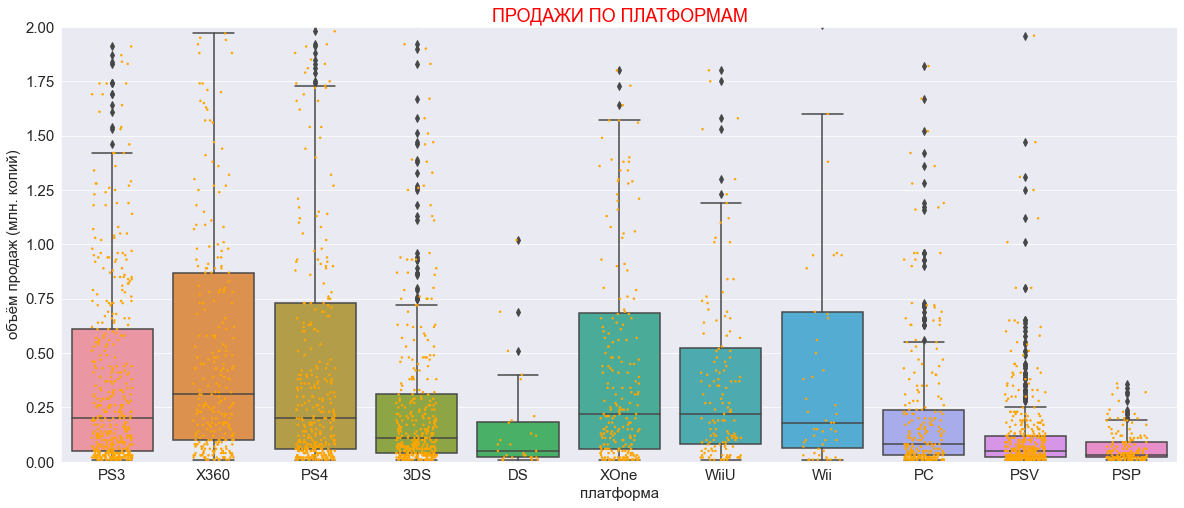

In [50]:
# построение и вывод графика
plt.figure(figsize=(20, 8))
ax = sns.boxplot(data=df_current_games, x='platform', y='total_sales')
ax = sns.stripplot(x='platform', y='total_sales', data=df_current_games, color="orange", jitter=0.2, size=2.5)
plt.title('ПРОДАЖИ ПО ПЛАТФОРМАМ', color='red')
plt.xlabel('платформа')
plt.ylabel('объём продаж (млн. копий)')
plt.ylim((0, 2))

plt.show()

In [51]:
# вывод информации
print("\033[1;31mМЕДИАННЫЕ ПРОДАЖИ ПО ПЛАТФОРМАМ\033[0m")
df_current_games.groupby('platform')['total_sales'].describe().sort_values('50%', ascending=False)['50%']

МЕДИАННЫЕ ПРОДАЖИ ПО ПЛАТФОРМАМ


platform
X360    0.31
WiiU    0.22
XOne    0.22
PS4     0.20
PS3     0.20
Wii     0.18
3DS     0.11
PC      0.08
DS      0.05
PSV     0.05
PSP     0.03
Name: 50%, dtype: float64

Самые высокие медианные продажи за акутальный период у платформы X360.  Далее идут WiiU, XOne и PS4.

### Влияние на продажи отзывов покупателей и критиков

Для оценки влияния отзывов покупателей и критиков на продажи создадим функции.

In [52]:
# создание функции
def def_interpret_pearson_corr(correlation):
    
    # описание функции
    """
    Функция интерпретирует значение корреляции Пирсона.

    Принимает на вход значение корреляции:
    - correlation - значение корреляции Пирсона

    """
    
    # интерпретация корреляции
    if correlation < -0.9:
        return 'очень сильная отрицательная корреляция'
    elif correlation < -0.7:
        return 'сильная отрицательная корреляция'
    elif correlation < -0.5:
        return 'заметная отрицательная корреляция'
    elif correlation < -0.3:
        return 'умеренная отрицательная корреляция'
    elif correlation < 0:
        return 'слабая отрицательная корреляция'
    elif correlation == 0:
        return 'отсутствие корреляции'
    elif correlation < 0.3:
        return 'слабая положительная корреляция'
    elif correlation < 0.5:
        return 'умеренная положительная корреляция'
    elif correlation < 0.7:
        return 'заметная положительная корреляция'
    elif correlation < 0.9:
        return 'сильная положительная корреляция'
    else:
        return 'очень сильная положительная корреляция'

In [53]:
# создание функции
def def_platform_analysis(platform):
    
    # описание функции
    """
    Функция определяет влияние пользователей и критиков на продажи
    
    Принимает на вход:
    - platform - название платформы

    """
    
    # создание среза
    platform_data = df_current_games.query('platform == @platform')
    
    
    # вывод заголовка
    print(f"\033[1;31m ПЛАТФОРМА {platform} - ЗАВИСИМОСТЬ ПРОДАЖ ОТ ОТЗЫВОВ\033[0m")

    # создание и вывод графиков
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Создание одной строки с двумя графиками
    sns.scatterplot(data=platform_data, x='critic_score', y='total_sales', ax=axes[0])
    axes[0].set_title(f' КРИТИКОВ ИГР',
                      color='darkred')
    axes[0].set_xlabel('отзывы критиков')
    axes[0].set_ylabel('объём продаж (млн. копий)')

    sns.scatterplot(data=platform_data, x='user_score', y='total_sales', ax=axes[1])
    axes[1].set_title(f'ПОЛЬЗОВАТЕЛЕЙ ИГР',
                      color='darkred')
    axes[1].set_xlabel('отзывы пользователей')
    axes[1].set_ylabel('объём продаж (млн. копий)')

    plt.tight_layout()
    plt.show()

    # вывод информации о корреляции
    corr_critics = round(platform_data['critic_score'].corr(platform_data['total_sales']), 2)
    print('Корреляция продаж и отзывов критиков игр на платформе', platform, 'составляет', corr_critics)
    print(f'Это значит, что между столбцами, {def_interpret_pearson_corr(corr_critics)}.')

    corr_users = round(platform_data['user_score'].corr(platform_data['total_sales']), 2)
    print('\nКорреляция продаж и отзывов пользователей игр на платформе', platform, 'составляет', corr_users)
    print(f'Это значит, что между столбцами, {def_interpret_pearson_corr(corr_users)}.')


Возьмём самую популярную платформу за актуальный период - PS4, и посмотрим, как влияют на продажи отзывы пользователей и критиков.

 ПЛАТФОРМА PS4 - ЗАВИСИМОСТЬ ПРОДАЖ ОТ ОТЗЫВОВ


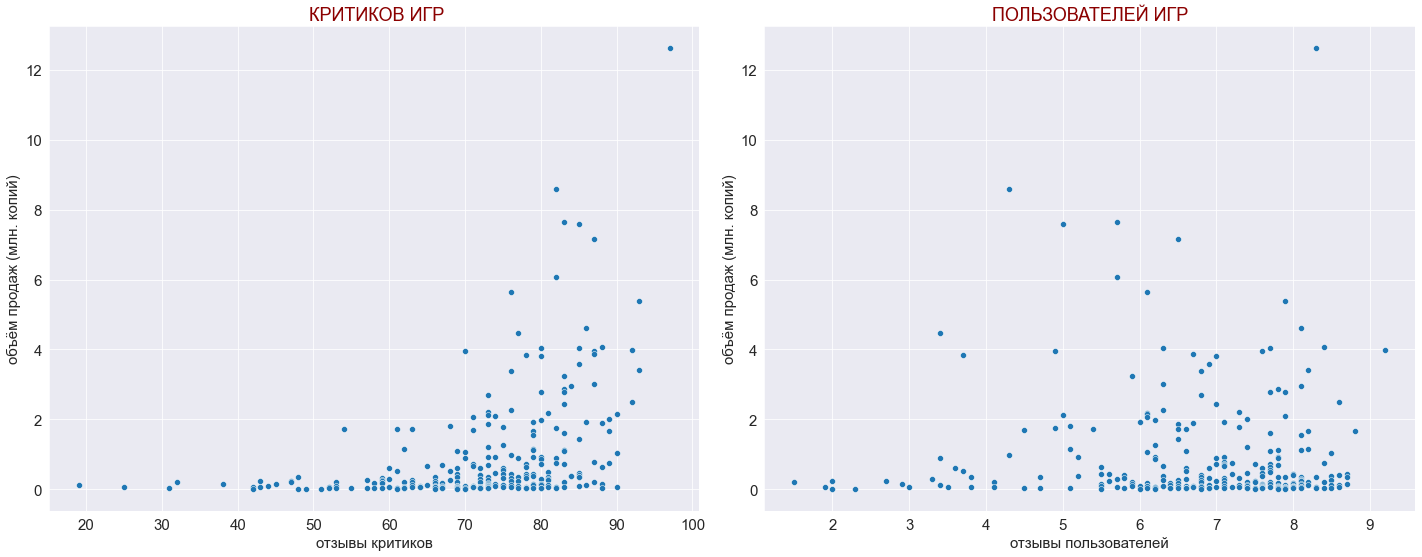

Корреляция продаж и отзывов критиков игр на платформе PS4 составляет 0.41
Это значит, что между столбцами, умеренная положительная корреляция.

Корреляция продаж и отзывов пользователей игр на платформе PS4 составляет -0.03
Это значит, что между столбцами, слабая отрицательная корреляция.


In [54]:
# вывод диаграммы рассеяния продаж и корреляции с помощью функции
def_platform_analysis("PS4")

Есть небольшое влияние на продажи отзывов критиков и нет заметного влияния отзывов пользователей на продажи. Возможно это связано с тем, что отзывам критиков пользователи доверяют больше. Также возможно, что отзывы критиков зависят от продаваемости игры.  
Посмотрим, совпадают ли наши наблюдения с играми на других популярных платформах.

 ПЛАТФОРМА X360 - ЗАВИСИМОСТЬ ПРОДАЖ ОТ ОТЗЫВОВ


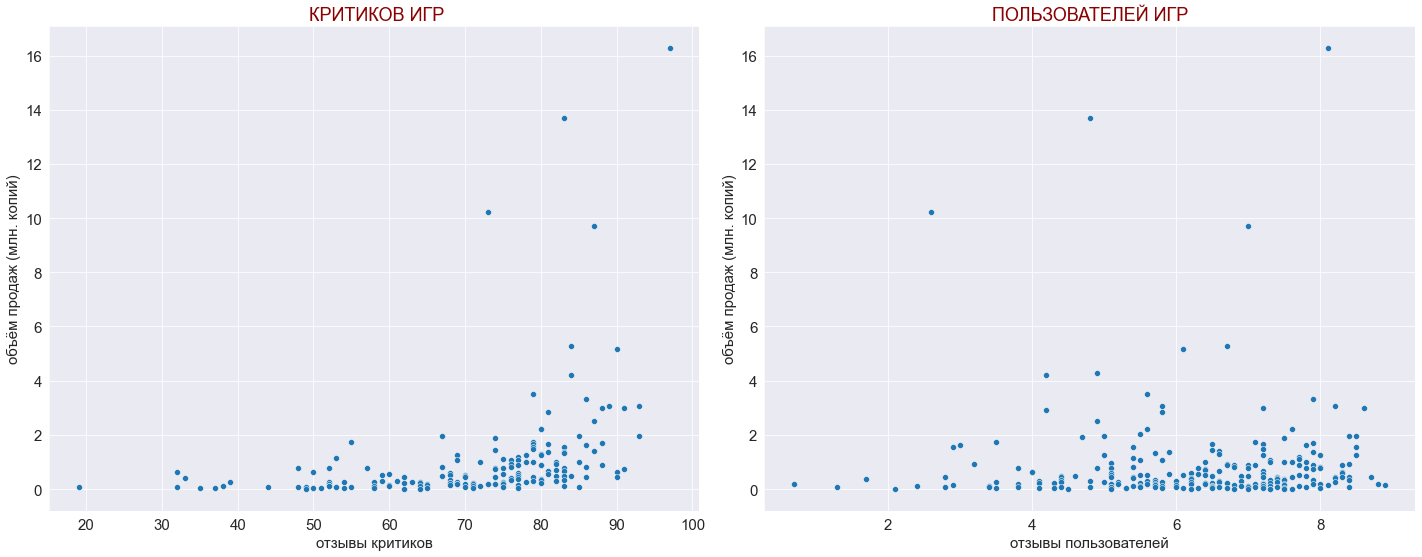

Корреляция продаж и отзывов критиков игр на платформе X360 составляет 0.36
Это значит, что между столбцами, умеренная положительная корреляция.

Корреляция продаж и отзывов пользователей игр на платформе X360 составляет 0.01
Это значит, что между столбцами, слабая положительная корреляция.


In [55]:
# вывод диаграммы рассеяния продаж и корреляции с помощью функции
def_platform_analysis("X360")

 ПЛАТФОРМА PS3 - ЗАВИСИМОСТЬ ПРОДАЖ ОТ ОТЗЫВОВ


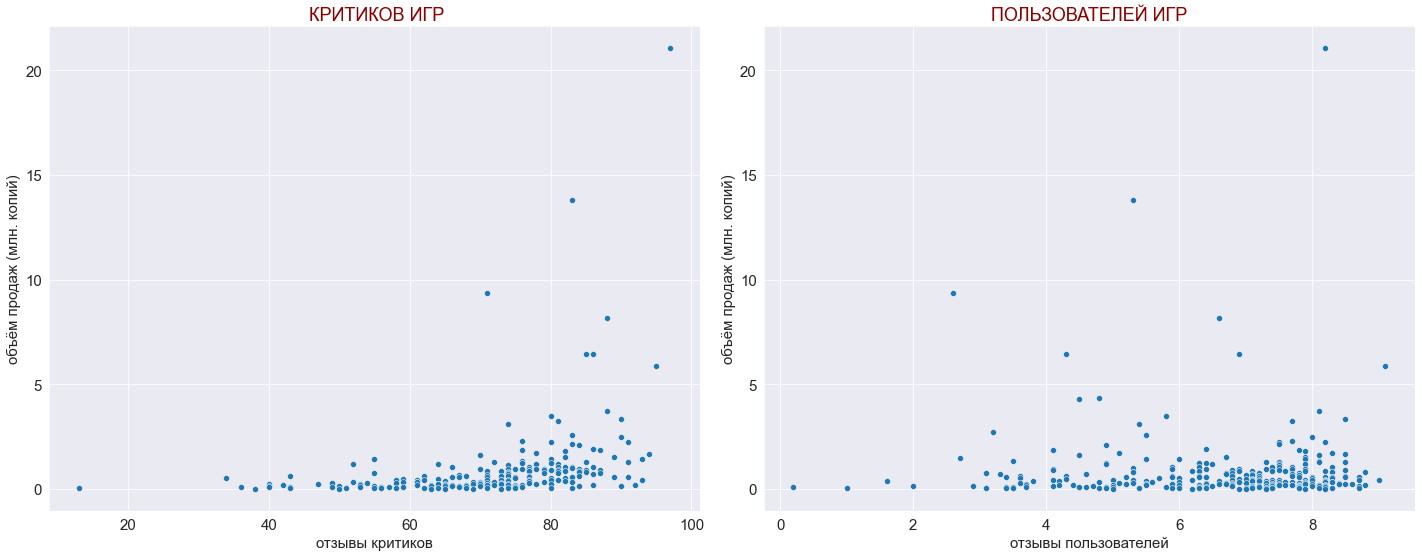

Корреляция продаж и отзывов критиков игр на платформе PS3 составляет 0.33
Это значит, что между столбцами, умеренная положительная корреляция.

Корреляция продаж и отзывов пользователей игр на платформе PS3 составляет -0.01
Это значит, что между столбцами, слабая отрицательная корреляция.


In [56]:
# вывод диаграммы рассеяния продаж и корреляции с помощью функции
def_platform_analysis("PS3")

 ПЛАТФОРМА XOne - ЗАВИСИМОСТЬ ПРОДАЖ ОТ ОТЗЫВОВ


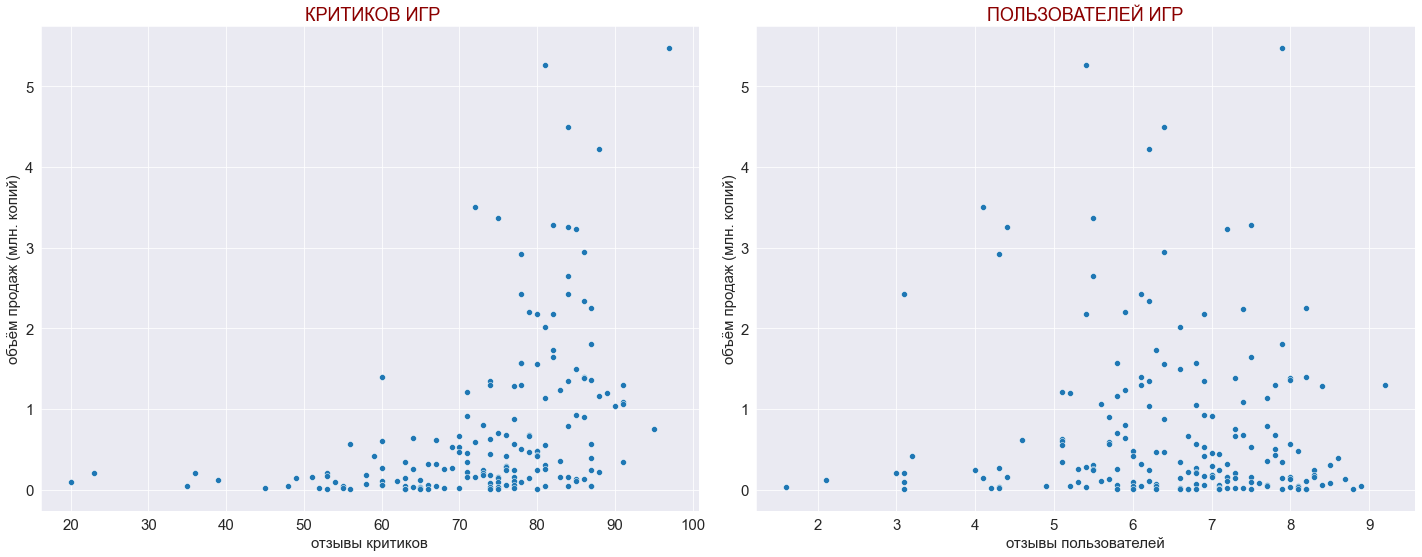

Корреляция продаж и отзывов критиков игр на платформе XOne составляет 0.42
Это значит, что между столбцами, умеренная положительная корреляция.

Корреляция продаж и отзывов пользователей игр на платформе XOne составляет -0.07
Это значит, что между столбцами, слабая отрицательная корреляция.


In [57]:
# вывод диаграммы рассеяния продаж и корреляции с помощью функции
def_platform_analysis("XOne")

 ПЛАТФОРМА WiiU - ЗАВИСИМОСТЬ ПРОДАЖ ОТ ОТЗЫВОВ


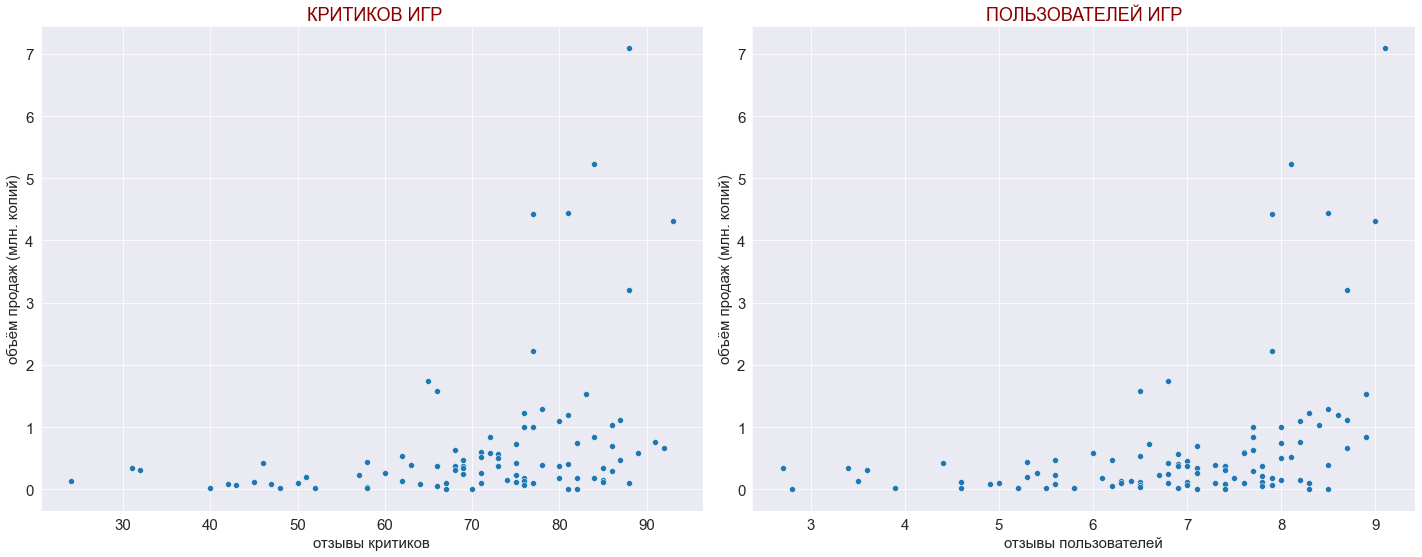

Корреляция продаж и отзывов критиков игр на платформе WiiU составляет 0.35
Это значит, что между столбцами, умеренная положительная корреляция.

Корреляция продаж и отзывов пользователей игр на платформе WiiU составляет 0.4
Это значит, что между столбцами, умеренная положительная корреляция.


In [58]:
# вывод диаграммы рассеяния продаж и корреляции с помощью функции
def_platform_analysis("WiiU")

Практически все платформы показывают схожие результаты: умеренная положительная корреляция между отзывами критиков и продажами, слабая корреляция между отзывами пользователей и продажами. Исключение - платформа WiiU (между отзывами пользователей и продажами здесь так же умеренная положительная корреляция). 

### Игры по жанрам

Посмотрим, как распределяются игры по жанрам в период с 2012 года.

,жанр,количество игр
0,Action,1031
7,Role-Playing,370
1,Adventure,302
10,Sports,267
8,Shooter,235
3,Misc,192
6,Racing,115
2,Fighting,109
4,Platform,85
9,Simulation,80


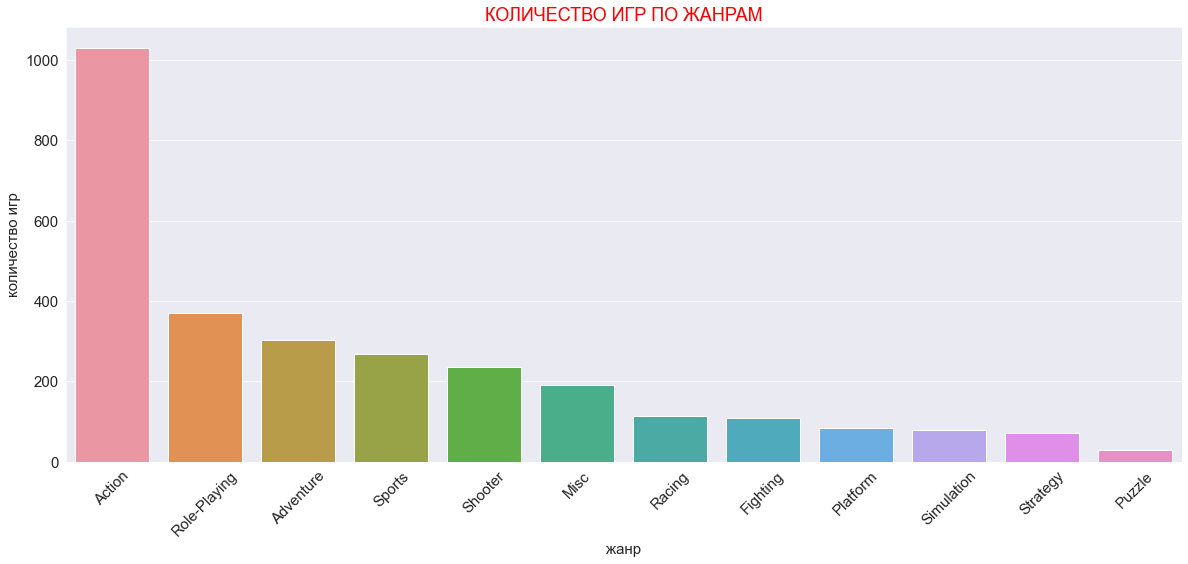

In [59]:
# вывод таблицы с помощью функции
def_count_games_by_column(df_current_games, 'genre', 'жанр', 'жанрам')

Самый популярный (выпускаемый) жанр - `Action` (1031 игра). Наименее популярный - `Puzzle` (28 игр).

Посмотрим, как продавались игры разного жанра.

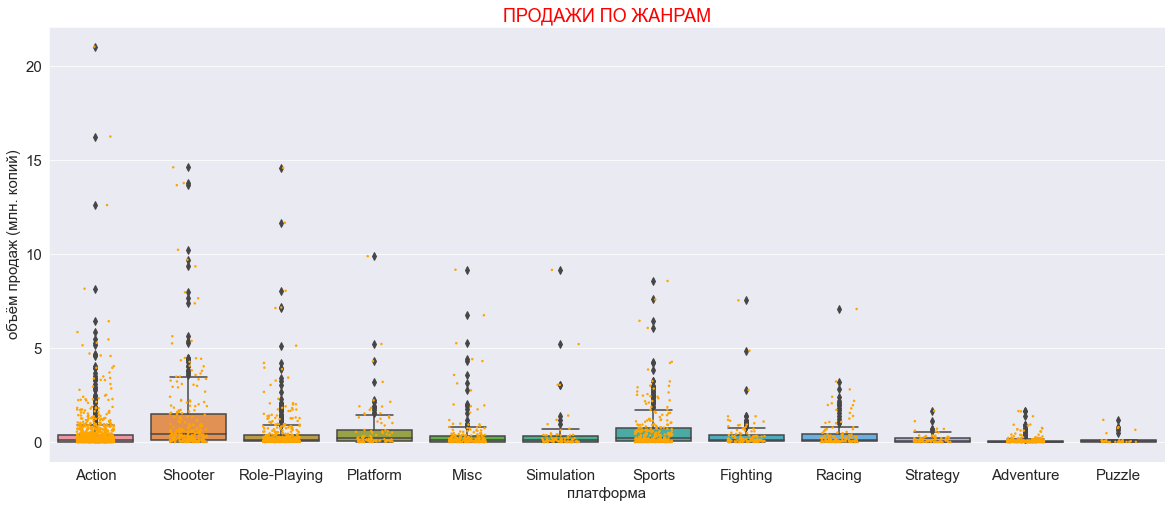

In [60]:
# создание и вывод графика
plt.figure(figsize=(20, 8))
ax = sns.boxplot(data=df_current_games, x='genre', y='total_sales')
ax = sns.stripplot(x='genre', y='total_sales', data=df_current_games, color="orange", jitter=0.2, size=2.5)
plt.title('ПРОДАЖИ ПО ЖАНРАМ', color='red')
plt.xlabel('платформа')
plt.ylabel('объём продаж (млн. копий)')

plt.show()

Опять видны значительные выбросы, поэтому посмотрим на этот график с масштабом.

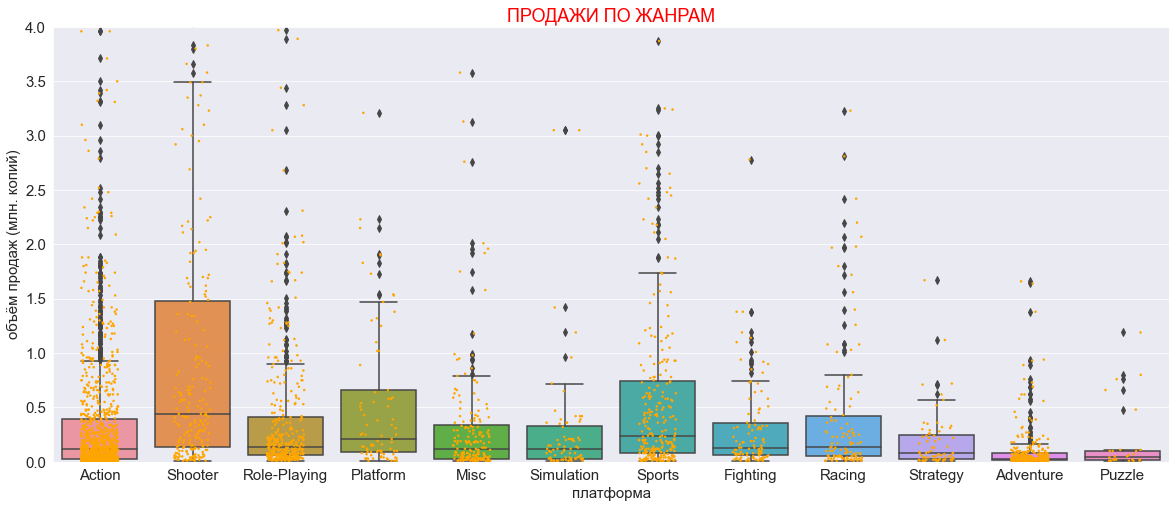

In [61]:
# создание и вывод графика
plt.figure(figsize=(20, 8))
ax = sns.boxplot(data=df_current_games, x='genre', y='total_sales')
ax = sns.stripplot(x='genre', y='total_sales', data=df_current_games, color="orange", jitter=0.2, size=2.5)
plt.title('ПРОДАЖИ ПО ЖАНРАМ', color='red')
plt.xlabel('платформа')
plt.ylabel('объём продаж (млн. копий)')
plt.ylim((0, 4))
plt.show()

In [62]:
# вывод информации
print("\033[1;31mМЕДИАННЫЕ ПРОДАЖИ ПО ЖАНРАМ\033[0m")
df_current_games.groupby('genre')['total_sales'].describe().sort_values('50%', ascending=False)['50%']

МЕДИАННЫЕ ПРОДАЖИ ПО ЖАНРАМ


genre
Shooter         0.44
Sports          0.24
Platform        0.21
Role-Playing    0.14
Racing          0.14
Fighting        0.13
Action          0.12
Misc            0.12
Simulation      0.12
Strategy        0.08
Puzzle          0.04
Adventure       0.03
Name: 50%, dtype: float64

Можно сделать вывод, что в среднем самые продаваемые игры относятся к жанру Shooter, после него идут жанры Sports и Platform. Но у жанра Action самые большие выбросы (скорее всего это самые продаваемые игры). Наименее продаваемые игры относятся к жанрам Puzzle и Adventure.

<div style="border:solid green 2px; padding: 20px">

<b>ВЫВОДЫ по разделу</b><br><br>
1. Мы изучили данные по годам: до 1993 года выпускалось не более 50 игр в год, начиная с 1993 идёт рост вплоть до 1426 игр в год в 2009 году. Далее начинается спад и с 2012 года выпускается около 500-600 игр в год.
2. Мы изучили данные по платформам, определив жизненный цикл платформ: средний срок жизни - 10 лет, пик продаж наступает в среднем через 4 года. Далее идёт спад.
3. Мы выделили актуальный период для исследования: с 2012 по 2016 годы - в это время стабилизировалось количество выпускаемых игр и данный период захватывает недавно появившиеся (более перспективные) платформы.
4. Мы изучили продажb по платформам. Наиболее популярная - PS4. Медианные продажи выше у X360, WiiU, XOne.
5. Изучили зависимость продаж от оценки критиков и пользователей, обнаружив, что оценка пользователей практически никогда не влияет на продажи, а оценка критиков влияет, но не очень сильно.
6. Определили самый популярный жанр: Action. Медианные продажи выше у Shooter, Sports, Platform.
    
</div>

## Портрет пользователя каждого региона

Для каждого региона определим самые популярные платформы и жанры. И посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

### Самые популярные платформы (топ-5)

Определим топ-5 популярных платформ по регионам.  
Для этого зададим функцию.

In [63]:
# создание функции
def def_top_for_regoins(column, title, text_resume):
        
    # описание функции
    """
    Функция создаёт графики распределения признака по регионам
    
    Принимает на вход:
    - column - столбец
    - title - заголовок
    - text_resume - поясняющий текст

    """
    
    # определение регионов
    regions = ['na_sales', 'eu_sales', 'jp_sales']
    popular_info = []

    # создание и вывод графика
    plt.figure(figsize=(20, 8)).suptitle(title, color='red')
    i = 1

    for region in regions:
        data = (
            df_current_games.groupby(column)
            .agg({region: 'sum'}).sort_values(by=region, ascending=False).head(5))
        plt.subplot(1, 3, i)
        plt.pie(
            data=data,
            x=region,
            labels=data.index,
            autopct='%.2f%%'
        )
        plt.title(region[:2].upper())

        most_popular = data.index[0]
        percentage = data.iloc[0][0] / data[region].sum() * 100
        popular_info \
        .append(
            f"{text_resume} {region[:2].upper()}: {most_popular} ({percentage:.2f}%)")

        i += 1

    plt.show()

    # вывод поясняющего текста (с лидерами по регионам)
    for info in popular_info:
        print(info)

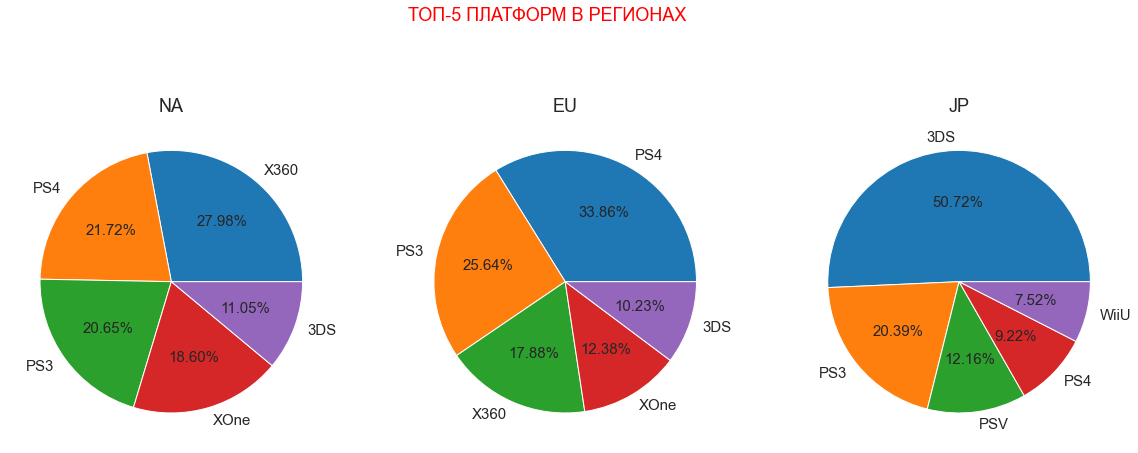

Самая популярная платформа в NA: X360 (27.98%)
Самая популярная платформа в EU: PS4 (33.86%)
Самая популярная платформа в JP: 3DS (50.72%)


In [64]:
# вывод графиков с помощью функции
def_top_for_regoins('platform', 'ТОП-5 ПЛАТФОРМ В РЕГИОНАХ', 'Самая популярная платформа в')

В каждом регионе своя платформа-лидер. Но интересно, что на втором месте в Северной Америке и Японии PS4 (в Европе она на первом месте). А лидирующая с большим отрывом в Японии 3DS (более 50%) в Северной Америке и Европе на последнем месте топа.

### Самые популярные жанры (топ-5)

Определим топ-5 популярных жанров по регионам.

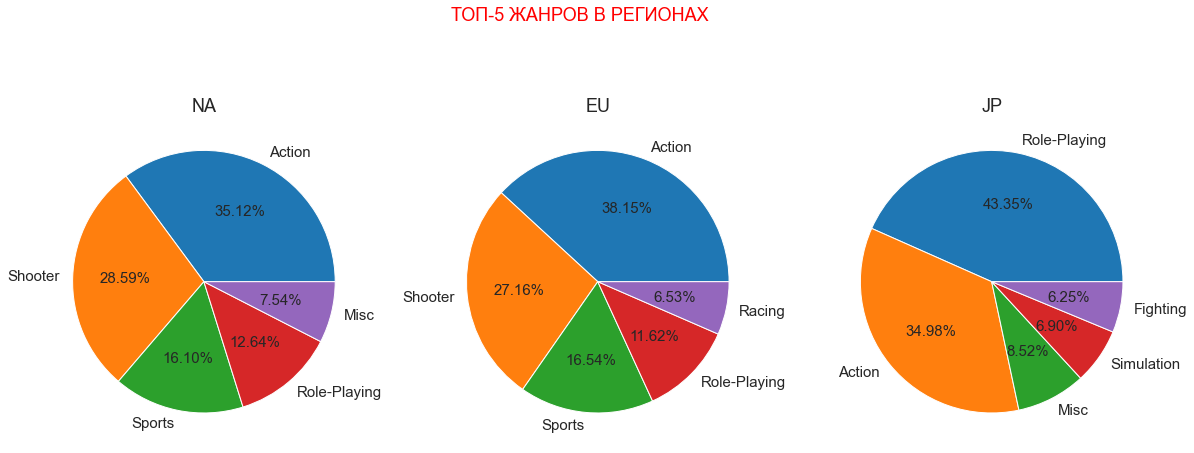

Самый популярный жанр в NA: Action (35.12%)
Самый популярный жанр в EU: Action (38.15%)
Самый популярный жанр в JP: Role-Playing (43.35%)


In [65]:
# вывод графиков с помощью функции
def_top_for_regoins('genre', 'ТОП-5 ЖАНРОВ В РЕГИОНАХ', 'Самый популярный жанр в')

По жарнрам Северная Америка и Европа показывают примерно одинаковую картину в целом (лидер - `Action` и остальные жанры одинаково распределились). А Япония сильно отличается даже по выбору жанров (на первом месте `Role-Playing`).

### Влияние рейтинга ESRB на продажи в регионах

Посмотрим, как рейтинг влияет ESRB на продажи в регионах.

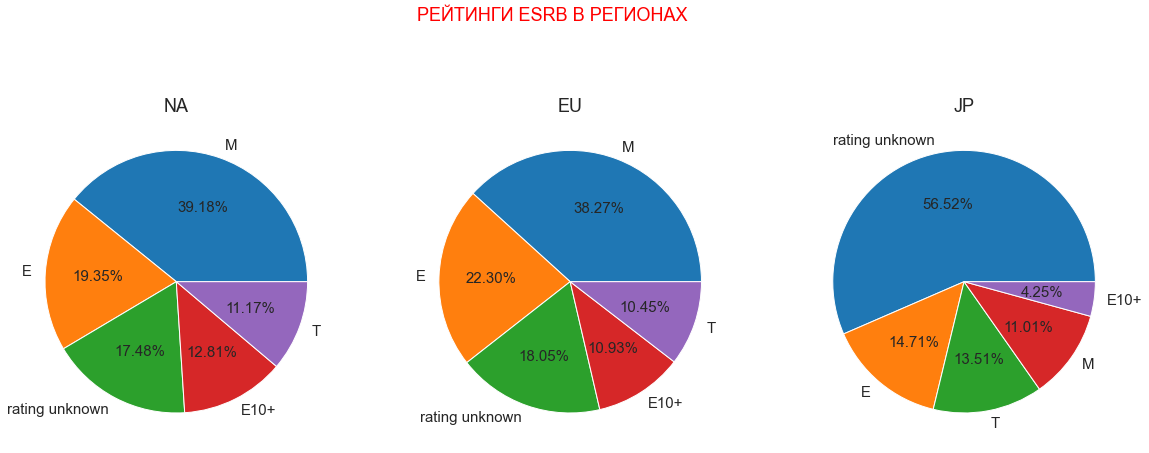

Самый популярный рейтинг в NA: M (39.18%)
Самый популярный рейтинг в EU: M (38.27%)
Самый популярный рейтинг в JP: rating unknown (56.52%)


In [66]:
# вывод графиков с помощью функции
def_top_for_regoins('rating', 'РЕЙТИНГИ ESRB В РЕГИОНАХ', 'Самый популярный рейтинг в')

В Северной Америке и Европе распределение продаж по рейтингу практически одинаковое, самый продаваемый рейтинг - M ("для взрослых"), после чего следуют E ("для всех") и игры без рейтинга.   
В Японии же с большим отрывом лидируют игры с отсутствующим рейтингом - скорее всего из-за того, чтг рейтингом игр для Японии занимается другая компания (CERO).

Соберём __ПОРТРЕТЫ ПОЛЬЗОВАТЕЛЕЙ ПО РЕГИОНАМ__.  


Среднестатистический пользователь компьютерных игр в `Северной Америке`:
- Чаще всего выбирает игровую консоль __X360 (28%)__, которая принадлежит американской компании Microsoft. Реже отдает предпочтение японским платформам __PS4 (22%)__ и __PS3 (21%)__.
- Предпочитает игры жанра __Action (35%)__ перед __Shooter (29%)__ или __Sports (16%)__.
- Приобретает игры с рейтингом __M__, изредка выбирая игры с рейтингом __E__ или игры __без рейтинга ESRB__.

Среднестатистический пользователь компьютерных игр в `Европе`:
- Чаще всего владеет игровой консолью __PS4 (34%)__. Он реже предпочитает __PS3 (26%)__ и __X360 (18)__.
- Предпочитает игры жанра __Action (38%)__ перед __Shooter (27%)__ или __Sports (17%)__.
- Покупает игры с рейтингом __M__, иногда выбирая игры с рейтингом __E__ или игры __без рейтинга ESRB__.

Среднестатистический пользователь компьютерных игр в `Японии`:
- Большинство пользователей предпочитают приставку __3DS (51%)__. Они реже выбирают __PS3 (20%)__ и __PSV (12%)__.
- Предпочитает игры жанра __Role-Playing (43%)__ перед __Action (35%)__ или __Misc (9%)__.
- Покупает игры __без рейтинга ESRB__, иногда выбирая игры с рейтингом __E__ или __T__.

<div style="border:solid green 2px; padding: 20px">

<b>ВЫВОДЫ по разделу</b><br><br>
1. Для каждого региона были определены самые популярные платформы, жанры и рейтинги ESRB.
2. Составлены портреты пользователей по регионам.
    
</div>

## Проверка гипотез

Проверим несколько гипотез.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

__Нулевая гипотеза (H_0)__: средний пользовательский рейтинг игр платформы `Xbox One` и средний пользовательский рейтинг платформы `PC` равны.

__Альтернативная гипотеза (H_1)__: средний пользовательский рейтинг игр платформы `Xbox One` и средний пользовательский рейтинг платформы `PC` __не__ равны.

Проверим эту гипотезу с помощью t-критерия Стьюдента.   
В качестве уровня статистической значимости возьмём alpha = 0.05. 
Посмотрим, насколько сопоставимы массивы, чтобы определить параметр `equal_var`.

In [67]:
# создание массивов для тестипования и вывод информации об их размерах
XOne_test = df_current_games.query('platform == "XOne"')['user_score']
PC_test = df_current_games.query('platform == "PC"')['user_score']

print(f"Размер массива `XOne`: {len(XOne_test)}")
print(f"Размер массива `PC`: {len(PC_test)}")

Размер массива `XOne`: 247
Размер массива `PC`: 250


Массивы сопоставимы - зададим для `equal_var` параметр True.

In [68]:
# проверка гипотезы
aplha = .05

results = st.ttest_ind(XOne_test, PC_test, equal_var=True,nan_policy='omit')

# вывод результата
print('p-значение:', results.pvalue)
if results.pvalue < aplha:
    print('Отвергаем нулевую гипотезу (то есть рейтинги не равны)')
else:
    print('Не получилось отвергнуть нулевую гипотезу (то есть рейтинги равны)')

p-значение: 0.5535080500642724
Не получилось отвергнуть нулевую гипотезу (то есть рейтинги равны)


Мы не смогли отвергнуть нулевую гипотезу: пользовательские рейтинги Xbox One и PC равны.  
Для проверки результатов теста посмотрим на значение среднего пользовательского рейтинга этих платформ.

In [69]:
# вывод информации
df_current_games.query('platform in ("XOne", "PC")').groupby('platform')['user_score'].mean()

platform
PC      6.43
XOne    6.52
Name: user_score, dtype: float64

Видим, что значения довольно близки (разница незначительная).

### Средние пользовательские рейтинги жанров Action и Sports разные

__Нулевая гипотеза (H_0)__: средний пользовательский рейтинг игр жанра `Action` и средний пользовательский рейтинг жанра `Sports` равны.

__Альтернативная гипотеза (H_1)__: средний пользовательский рейтинг игр жанра `Action` и средний пользовательский рейтинг жанра `Sports` __не__ равны.

Для проверки этой гипотезы также воcпользуемся t-критерием Стьюдента и также установим уровень статистической значимости alpha = 0.05.

In [70]:
# создание массивов для тестипования и вывод информации об их размерах
Action_test = df_current_games.query('genre == "Action"')['user_score']
Sports_test = df_current_games.query('genre == "Sports"')['user_score']

print(f"Размер массива `XOne`: {len(Action_test)}")
print(f"Размер массива `PC`: {len(Sports_test)}")

Размер массива `XOne`: 1031
Размер массива `PC`: 267


Массивы не сопоставимы, поэтому для `equal_var` параметр False.

In [71]:
# проверка гипотезы
aplha = .05

results = st.ttest_ind(
    Action_test, 
    Sports_test, 
    equal_var=False,
    nan_policy='omit'
)

# вывод результата
print('p-значение:', results.pvalue)
if results.pvalue < aplha:
    print('Отвергаем нулевую гипотезу (то есть значения не равны)')
else:
    print('Не получилось отвергнуть нулевую гипотезу (то есть значения равны)')

p-значение: 5.989458066467624e-20
Отвергаем нулевую гипотезу (то есть значения не равны)


Отвергаем нулевую гипотезу: пользовательские рейтинги жанров Action и Sports равны.  
Для проверки результатов теста посмотрим на значение среднего пользовательского рейтинга этих жанров.

In [72]:
# вывод информации
df_current_games.query('genre in ("Action", "Sports")').groupby('genre')['user_score'].mean()

genre
Action    6.83
Sports    5.46
Name: user_score, dtype: float64

Здесь разница уже более существенная.

<div style="border:solid green 2px; padding: 20px">

<b>ВЫВОДЫ по разделу</b><br><br>
Оценки пользователей не зависят от платформ, но зависят от жанров игр. С учётом принятого нами значения критического уровня статистической значимости 5% мы выяснили, что первая гипотеза не может быть отвергнута, а вторая отвергнута.
</div>

## Выводы

 <div style="border: solid green 4px; border-style: double; padding: 20px;">
    <b>ВЫВОДЫ ПО ПРОЕКТУ</b>
    
В рамках данного исследования была проанализированы данные об играх, выпущенных на различных платформах и проданных в нескольких регионах. 
Нам были доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. После предобработки в нашем распоряжении были данные о 11425 играх на 31 игровой платформе, представляющих 12 различных жанров, выпущенных в одном или нескольких релизах в период с 1980 по 2016 год.

Диапазон дат датасета: 1980 - 2016 гг.

<b>ПЕРЕРАБОТКА ИСХОДНЫХ ДАННЫХ</b><br>
Были обработаны пропуски, исправлены типы данных, названия столбцов приведены к "хорошему" стилю. Также была добавлена информаци об общих продажах игр во всех регионах.
    
<b>ИССЛЕДОВАНИЕ</b><br>
В ходе исследования мы определили:
- До 1993 года количество выпускаемых игр было очень небольшим (до 50 в год), после начался рост вплоть до 2008-2009 годов (с пиком в 2009, когда было выпущено 1426 игр). После 2009 года началось падение и с 2012 года выпускается 500-600 игр в год.
- Больше всего игр было выпущено на платформе PS2, после этой платформы следуют X360 и PS3.
- Лайфтам платформ составляет 10 лет (средний и медианный срок жизни платформы). Пик продаж приходится в среднем на 4 год выпуска платформы.

Был выделен актуальный период исследования: с 2012 года по настоящее время (по 2016 год) и сделаны следующие наблюдения:
- Наибольшее количество продаж приходится на платформу PS4. Далее следуют PS3 и X360.
- Самыми перспективными можно считать консоли нового поколения PS4 и XOne.
- Обнаружена умеренная корреляция между отзывами критиков и продажами. Между отзывами пользователей и продажами почти всегда отсутствует значимая корреляция.
- По количеству игр с большим отрывом лидирует жанр Action (в этом же жанре самые большие выбросы -то есть самые продаваемые игры). В среднем самые продаваемые игры относятся к жанру Shooter, после него идут жанры Sports и Platform.
    
<b>ПОРТРЕТЫ ПОЛЬЗОВАТЕЛЕЙ</b><br>
Мы составили <b>портреты пользователей игр из Северной Америки, из Европы и из Японии</b>.
- В Америке у пользователя чаще всего приставка X360, он играет в игры жанра Action и игры рейтинга "М"
- В Европе у пользователя чаще всего приставка PS4, он играет в игры жанра Action и игры рейтинга "М"
- В Японии у пользователя чаще всего приставка 3DS, он играет в игры жанра Role-Playing и игры без рейтинга ESRB


<b>ГИПОТЕЗЫ</b><br>
Мы проверили две гипотезы с помощью t-критерия Стьюдента и выяснили, что:
- средний пользовательский рейтинг игр платформы Xbox One и средний пользовательский рейтинг платформы PC равны
- средний пользовательский рейтинг игр жанра Action и средний пользовательский рейтинг жанра Sports разные
    
    
<b>РЕКОМЕНДАЦИИ</b><br>
Для планирования рекламных кампаний мы рекомендуем обратить внимание на игры жанра <b>Action</b> или <b>Shooter</b>, которые выходят на консолях нового поколения <b>Xbox One</b> или <b>Playstation 4</b>, а также которые имеют рейтинг <b>"M" ("Mature")</b>. 
Для пользователей из Японии следует обратить внимание на игры жанра <b>Role-Playing</b>, выходящие на платформе <b>Nintendo 3DS</b>, не учитывая рейтинг ESRB.
    
Также стоит обратить внимание на отзывы критиков. При этом оценки пользователей учитывать при проведении рекламных кампаний не так важно.
    
</div>